Friday US SP500 Movements vs Monday SP500 ETF Movement in JPY

In [4]:
from tiportfolio.helpers.data import Alpaca
import dotenv

dotenv.load_dotenv()

import os
alpaca = Alpaca(os.environ['ALPACA_API_KEY'], os.environ['ALPACA_API_SECRET'])

In [5]:
from tiportfolio.helpers.data import YFinance
yfinance = YFinance()

In [6]:
# get spy
spy_df = yfinance.query('SPY', '2020-01-01', '2024-12-31', '1D', 'all')
spy_df

Loading bar data...


[*********************100%***********************]  1 of 1 completed

Loaded bar data: 0:00:02 



,date,symbol,open,high,low,close,volume,adj_close
0,2020-01-02,SPY,323.540009,324.890015,322.529999,324.869995,59151200,298.578674
1,2020-01-03,SPY,321.160004,323.640015,321.100006,322.410004,77709700,296.317749
2,2020-01-06,SPY,320.489990,323.730011,320.359985,323.640015,55653900,297.448212
3,2020-01-07,SPY,323.019989,323.540009,322.239990,322.730011,40496400,296.611877
4,2020-01-08,SPY,322.940002,325.779999,322.670013,324.450012,68296000,298.192657
...,...,...,...,...,...,...,...,...
1252,2024-12-23,SPY,590.890015,595.299988,587.659973,594.690002,57635800,589.524353
1253,2024-12-24,SPY,596.059998,601.340027,595.469971,601.299988,33160100,596.076904
1254,2024-12-26,SPY,599.500000,602.479980,598.080017,601.340027,41219100,596.116699
1255,2024-12-27,SPY,597.539978,597.780029,590.760010,595.010010,64969300,589.841614


In [7]:
# get 2558.T
etf_jp_df = yfinance.query('2558.T', '2018-01-01', '2024-12-31', '1D', 'all')
etf_jp_df

Loading bar data...


[*********************100%***********************]  1 of 1 completed

Loaded bar data: 0:00:01 



,date,symbol,open,high,low,close,volume,adj_close
0,2020-01-07,2558.T,9917.0,9917.0,9917.0,9917.0,0,9333.500977
1,2020-01-08,2558.T,9917.0,9917.0,9917.0,9917.0,0,9333.500977
2,2020-01-09,2558.T,10097.0,10097.0,10097.0,10097.0,0,9502.913086
3,2020-01-10,2558.T,10300.0,10320.0,10280.0,10320.0,2502,9712.788086
4,2020-01-14,2558.T,10390.0,10400.0,10350.0,10370.0,5739,9759.845703
...,...,...,...,...,...,...,...,...
1216,2024-12-24,2558.T,26940.0,26985.0,26900.0,26910.0,35630,26644.300781
1217,2024-12-25,2558.T,27190.0,27230.0,27100.0,27200.0,53980,26931.437500
1218,2024-12-26,2558.T,27210.0,27295.0,27210.0,27270.0,71315,27000.746094
1219,2024-12-27,2558.T,27375.0,27385.0,27290.0,27305.0,86155,27035.400391


Get close from each, and merge them together, since they have different trading days, we do an outer join.

3 Columns to keep:
- date (as index)
- spy_adj_close
- etf_jp_adj_close
- spy_open
- etf_jp_open

In [8]:
import pandas as pd

# select required columns (assumes 'adj_close' column exists from YFinance with auto_adjust=False)
spy_sel = spy_df[['date', 'open', 'adj_close']].copy()
etf_sel = etf_jp_df[['date', 'open', 'adj_close']].copy()

# rename columns to identify source
spy_sel.rename(columns={'adj_close': 'spy_adj_close', 'open': 'spy_open'}, inplace=True)
etf_sel.rename(columns={'adj_close': 'etf_jp_adj_close', 'open': 'etf_jp_open'}, inplace=True)

# outer join on the date column (dates are ISO-local strings per notebook comment)
merged = pd.merge(spy_sel, etf_sel, on='date', how='outer')

# coerce price columns to numeric to ensure consistent dtypes
price_cols = ['spy_adj_close', 'etf_jp_adj_close', 'spy_open', 'etf_jp_open']
for col in price_cols:
    if col in merged.columns:
        merged[col] = pd.to_numeric(merged[col], errors='coerce')

# set date as index and sort
merged = merged.set_index('date').sort_index()

# quick sanity output
print(f"Merged rows: {len(merged)}")
print("Missing values per column:")
print(merged[price_cols].isna().sum())

# show the first few rows
merged

Merged rows: 1299
Missing values per column:
spy_adj_close       42
etf_jp_adj_close    78
spy_open            42
etf_jp_open         78
dtype: int64


,spy_open,spy_adj_close,etf_jp_open,etf_jp_adj_close
date,,,,
2020-01-02,323.540009,298.578674,NaN,NaN
2020-01-03,321.160004,296.317749,NaN,NaN
2020-01-06,320.489990,297.448212,NaN,NaN
2020-01-07,323.019989,296.611877,9917.0,9333.500977
2020-01-08,322.940002,298.192657,9917.0,9333.500977
...,...,...,...,...
2024-12-24,596.059998,596.076904,26940.0,26644.300781
2024-12-25,NaN,NaN,27190.0,26931.437500
2024-12-26,599.500000,596.116699,27210.0,27000.746094


In [9]:
# calculate (close - open) / open for spy and etf_jp of each row
merged['spy_return'] = (merged['spy_adj_close'] - merged['spy_open']) / merged['spy_open']
merged['etf_jp_return'] = (merged['etf_jp_adj_close'] - merged['etf_jp_open']) / merged['etf_jp_open']
merged

,spy_open,spy_adj_close,etf_jp_open,etf_jp_adj_close,spy_return,etf_jp_return
date,,,,,,
2020-01-02,323.540009,298.578674,NaN,NaN,-0.077151,NaN
2020-01-03,321.160004,296.317749,NaN,NaN,-0.077352,NaN
2020-01-06,320.489990,297.448212,NaN,NaN,-0.071895,NaN
2020-01-07,323.019989,296.611877,9917.0,9333.500977,-0.081754,-0.058838
2020-01-08,322.940002,298.192657,9917.0,9333.500977,-0.076631,-0.058838
...,...,...,...,...,...,...
2024-12-24,596.059998,596.076904,26940.0,26644.300781,0.000028,-0.010976
2024-12-25,NaN,NaN,27190.0,26931.437500,NaN,-0.009509
2024-12-26,599.500000,596.116699,27210.0,27000.746094,-0.005644,-0.007690


Now we want to find the relation between each Friday, US SPY Close - Open return vs next Monday (or next non NaN day in etf_jp columns), Japan ETF Close - Open return.

In [10]:
# Pair each Friday SPY return with the next non-NaN JP ETF return (check up to 3 market rows ahead)
import numpy as np
import matplotlib.pyplot as plt
import os

# defensive copy
_df = merged.copy()

# ensure datetime index for weekday operations
_df.index = pd.to_datetime(_df.index)

# compute returns if not already present
if 'spy_return' not in _df.columns:
    _df['spy_return'] = (_df['spy_adj_close'] - _df['spy_open']) / _df['spy_open']
if 'etf_jp_return' not in _df.columns:
    _df['etf_jp_return'] = (_df['etf_jp_adj_close'] - _df['etf_jp_open']) / _df['etf_jp_open']

# reset index so we can use positional lookups
_reset = _df.reset_index().rename(columns={'index': 'date'})

pairs = []
N = len(_reset)

for i, row in _reset.iterrows():
    # only Fridays
    if row['date'].weekday() != 4:
        continue
    # require spy return
    if pd.isna(row.get('spy_return')):
        continue

    matched = None
    # check next 1..3 rows for first non-NaN etf_jp_return
    for ahead in range(1, 4):
        j = i + ahead
        if j >= N:
            break
        candidate = _reset.at[j, 'etf_jp_return']
        if not pd.isna(candidate):
            matched = {
                'date': row['date'].date().isoformat(),
                'spy_friday_return': float(row['spy_return']),
                'etf_matched_date': _reset.at[j, 'date'].date().isoformat(),
                'etf_next_return': float(candidate),
                'rows_ahead': ahead,
            }
            break
    if matched is not None:
        pairs.append(matched)

pairs_df = pd.DataFrame(pairs)

print(f"Total Fridays considered: {_reset['date'].dt.weekday.eq(4).sum()}")
print(f"Total Fridays matched: {len(pairs_df)}")


pairs_df

Total Fridays considered: 260
Total Fridays matched: 250


,friday_date,spy_friday_return,etf_matched_date,etf_next_return,rows_ahead
0,2020-01-03,-0.077352,2020-01-07,-0.058838,2
1,2020-01-10,-0.085366,2020-01-14,-0.060650,2
2,2020-01-17,-0.080236,2020-01-20,-0.062414,1
3,2020-01-24,-0.091075,2020-01-27,-0.071569,1
4,2020-01-31,-0.095741,2020-02-03,-0.062547,1
...,...,...,...,...,...
245,2024-11-29,-0.007250,2024-12-02,-0.012953,1
246,2024-12-06,-0.011410,2024-12-09,-0.009118,1
247,2024-12-13,-0.015580,2024-12-16,-0.008202,1
248,2024-12-20,0.007297,2024-12-23,-0.007839,1



SPY Friday return summary:
count    250.000000
mean      -0.043588
std        0.023094
min       -0.127861
25%       -0.062006
50%       -0.043668
75%       -0.023629
max        0.007297
Name: spy_friday_return, dtype: float64

ETF next return summary:
count    250.000000
mean      -0.038192
std        0.016526
min       -0.116792
25%       -0.050391
50%       -0.039004
75%       -0.025404
max       -0.007576
Name: etf_next_return, dtype: float64

Pearson correlation: 0.8271
Linear fit: etf_next_return = 0.591837 * spy_friday_return + -1.239539e-02


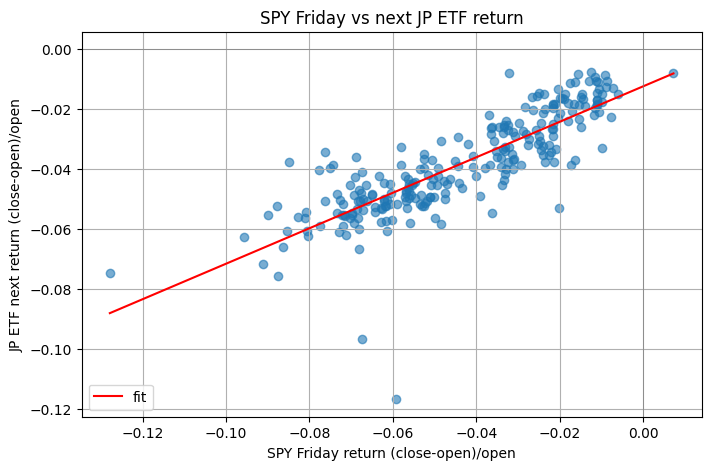

Saved pairs CSV to: /Users/tim/Development/TiPortfolio/research/friday_spy_vs_next_etf_pairs.csv


In [11]:
if pairs_df.empty:
    print("No matched pairs found. Inspect `merged` to ensure ETF JP data exists after Fridays.")
else:
    # basic summaries
    print('\nSPY Friday return summary:')
    print(pairs_df['spy_friday_return'].describe())
    print('\nETF next return summary:')
    print(pairs_df['etf_next_return'].describe())

    # correlation
    corr = pairs_df['spy_friday_return'].corr(pairs_df['etf_next_return'])
    print(f"\nPearson correlation: {corr:.4f}")

    # linear fit (OLS slope/intercept)
    x = pairs_df['spy_friday_return'].values
    y = pairs_df['etf_next_return'].values
    slope, intercept = np.polyfit(x, y, 1)
    print(f"Linear fit: etf_next_return = {slope:.6f} * spy_friday_return + {intercept:.6e}")

    # scatter plot with fit line
    plt.figure(figsize=(8, 5))
    plt.scatter(x, y, alpha=0.6)
    xs = np.linspace(x.min(), x.max(), 100)
    plt.plot(xs, slope * xs + intercept, color='red', label='fit')
    plt.axhline(0, color='gray', linewidth=0.5)
    plt.axvline(0, color='gray', linewidth=0.5)
    plt.xlabel('SPY Friday return (close-open)/open')
    plt.ylabel('JP ETF next return (close-open)/open')
    plt.title('SPY Friday vs next JP ETF return')
    plt.legend()
    plt.grid(True)
    plt.show()

    # save the pairs to CSV in the current working directory
    out_path = os.path.join(os.getcwd(), 'us_friday_spy_vs_jp_next_etf_pairs.csv')
    pairs_df.to_csv(out_path, index=False)
    print(f"Saved pairs CSV to: {out_path}")

In [12]:
import numpy as np

In [13]:
# now let create a new column, direction if both are positive or both are negative, direction is 1, else -1


pairs_df['direction'] = np.where(
    (pairs_df['spy_friday_return'] * pairs_df['etf_next_return']) > 0, 1, -1
)
pairs_df

,friday_date,spy_friday_return,etf_matched_date,etf_next_return,rows_ahead,direction
0,2020-01-03,-0.077352,2020-01-07,-0.058838,2,1
1,2020-01-10,-0.085366,2020-01-14,-0.060650,2,1
2,2020-01-17,-0.080236,2020-01-20,-0.062414,1,1
3,2020-01-24,-0.091075,2020-01-27,-0.071569,1,1
4,2020-01-31,-0.095741,2020-02-03,-0.062547,1,1
...,...,...,...,...,...,...
245,2024-11-29,-0.007250,2024-12-02,-0.012953,1,1
246,2024-12-06,-0.011410,2024-12-09,-0.009118,1,1
247,2024-12-13,-0.015580,2024-12-16,-0.008202,1,1
248,2024-12-20,0.007297,2024-12-23,-0.007839,1,-1


In [16]:
# get summary of direction
direction_summary = pairs_df['direction'].value_counts()

# in percentage
direction_percentage = pairs_df['direction'].value_counts(normalize=True) * 100
print("Direction Summary:")
print(direction_summary)
print("\nDirection Percentage:")
print(direction_percentage)

Direction Summary:
direction
 1    249
-1      1
Name: count, dtype: int64

Direction Percentage:
direction
 1    99.6
-1     0.4
Name: proportion, dtype: float64


In [17]:
# show the opposite direction rows
opposite_direction = pairs_df[pairs_df['direction'] == -1]
opposite_direction

,friday_date,spy_friday_return,etf_matched_date,etf_next_return,rows_ahead,direction
248,2024-12-20,0.007297,2024-12-23,-0.007839,1,-1


## Conclusion
We can conclude that the Friday US SPY Return and Monday JPY SP500 ETF has a strong correlation, and the direction is about 99.6% same direction.

## Now we can try find JP Friday SP500 ETF and next Friday US SPY Movement

This could work, because Japan market open first, the trade in JPY, it will reflect to US market on the same day.

In [18]:
jp_friday_pairs = []
N = len(_reset)

for i, row in _reset.iterrows():
    # only Fridays
    if row['date'].weekday() != 4:
        continue
    # require etf_jp return
    if pd.isna(row.get('etf_jp_return')):
        continue

    matched = None
    # check same day row of US SPY return because of time zone difference
    j = i
    if j < N:
        candidate = _reset.at[j, 'spy_return']
        if not pd.isna(candidate):
            matched = {
                'date': row['date'].date().isoformat(),
                'etf_jp_friday_return': float(row['etf_jp_return']),
                'spy_next_return': float(candidate),
            }
    if matched is not None:
        jp_friday_pairs.append(matched)


jp_pairs_df = pd.DataFrame(jp_friday_pairs)
jp_pairs_df

,jp_friday_date,etf_jp_friday_return,spy_matched_date,spy_next_return
0,2020-01-10,-0.057011,2020-01-10,-0.085366
1,2020-01-17,-0.057937,2020-01-17,-0.080236
2,2020-01-24,-0.058838,2020-01-24,-0.091075
3,2020-01-31,-0.058838,2020-01-31,-0.095741
4,2020-02-07,-0.060629,2020-02-07,-0.082641
...,...,...,...,...
234,2024-11-29,-0.021604,2024-11-29,-0.007250
235,2024-12-06,-0.017099,2024-12-06,-0.011410
236,2024-12-13,-0.007635,2024-12-13,-0.015580
237,2024-12-20,-0.016770,2024-12-20,0.007297


In [19]:
# calculate direction
jp_pairs_df['direction'] = np.where(
    (jp_pairs_df['etf_jp_friday_return'] * jp_pairs_df['spy_next_return']) > 0, 1, -1
)
# calculate summary of direction in percentage
jp_direction_summary = jp_pairs_df['direction'].value_counts()
jp_direction_percentage = jp_pairs_df['direction'].value_counts(normalize=True) * 100
print("JP Friday to US SPY Next Friday Direction Summary:")
print(jp_direction_summary)
print("\nJP Friday to US SPY Next Friday Direction Percentage:")
print(jp_direction_percentage)

JP Friday to US SPY Next Friday Direction Summary:
direction
 1    238
-1      1
Name: count, dtype: int64

JP Friday to US SPY Next Friday Direction Percentage:
direction
 1    99.58159
-1     0.41841
Name: proportion, dtype: float64


In [20]:
# show the opposite direction rows
jp_opposite_direction = jp_pairs_df[jp_pairs_df['direction'] == -1]
jp_opposite_direction

,jp_friday_date,etf_jp_friday_return,spy_matched_date,spy_next_return,direction
237,2024-12-20,-0.01677,2024-12-20,0.007297,-1


In [21]:
# calculate correlation



JP Friday to US SPY Next Friday Pearson correlation: 0.8567



ETF return summary:
count    239.000000
mean      -0.038231
std        0.016469
min       -0.086067
25%       -0.049982
50%       -0.039211
75%       -0.023860
max       -0.007009
Name: etf_jp_friday_return, dtype: float64

SPY Friday following return summary:
count    239.000000
mean      -0.043333
std        0.022602
min       -0.095741
25%       -0.061745
50%       -0.043312
75%       -0.023641
max        0.007297
Name: spy_next_return, dtype: float64

JP Friday to US SPY Next Friday Pearson correlation: 0.8567
Linear fit: etf_next_return = 1.175720 * spy_friday_return + 1.616308e-03


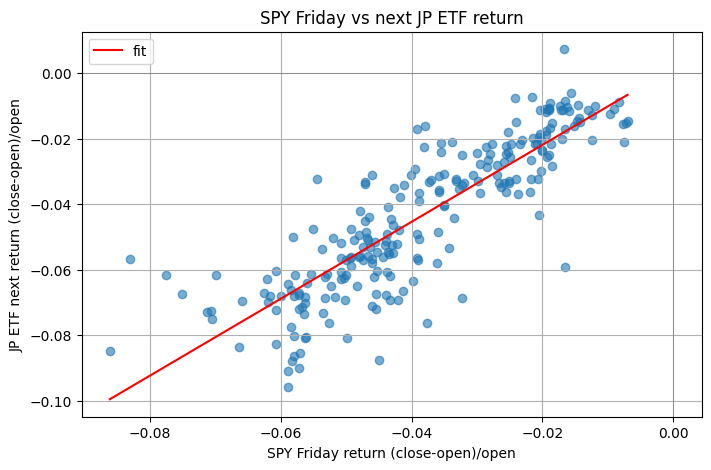

Saved pairs CSV to: /Users/tim/Development/TiPortfolio/research/jp_friday_spy_vs_us_etf_pairs.csv


In [22]:
if jp_pairs_df.empty:
    print("No matched jp friday pairs found. Inspect `merged` to ensure ETF JP data exists after Fridays.")
else:
    # basic summaries
    print('\nETF return summary:')
    print(jp_pairs_df['etf_jp_friday_return'].describe())
    print('\nSPY Friday following return summary:')
    print(jp_pairs_df['spy_next_return'].describe())


    # correlation
    jp_corr = jp_pairs_df['etf_jp_friday_return'].corr(jp_pairs_df['spy_next_return'])
    print(f"\nJP Friday to US SPY Next Friday Pearson correlation: {jp_corr:.4f}")

    # linear fit (OLS slope/intercept)
    x = jp_pairs_df['etf_jp_friday_return'].values
    y = jp_pairs_df['spy_next_return'].values
    slope, intercept = np.polyfit(x, y, 1)
    print(f"Linear fit: etf_next_return = {slope:.6f} * spy_friday_return + {intercept:.6e}")

    # scatter plot with fit line
    plt.figure(figsize=(8, 5))
    plt.scatter(x, y, alpha=0.6)
    xs = np.linspace(x.min(), x.max(), 100)
    plt.plot(xs, slope * xs + intercept, color='red', label='fit')
    plt.axhline(0, color='gray', linewidth=0.5)
    plt.axvline(0, color='gray', linewidth=0.5)
    plt.xlabel('SPY Friday return (close-open)/open')
    plt.ylabel('JP ETF next return (close-open)/open')
    plt.title('SPY Friday vs next JP ETF return')
    plt.legend()
    plt.grid(True)
    plt.show()

    # save the pairs to CSV in the current working directory
    out_path = os.path.join(os.getcwd(), 'jp_friday_spy_vs_us_etf_pairs.csv')
    jp_pairs_df.to_csv(out_path, index=False)
    print(f"Saved pairs CSV to: {out_path}")